In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
n_samples = 1000

# create circles

In [3]:
X, y = make_circles(n_samples,noise=.07,random_state=42)

In [4]:
X[:5], y[:5]

(array([[ 0.7301675 ,  0.26189078],
        [-0.71190572,  0.1841244 ],
        [-0.8443255 ,  0.27063595],
        [-0.46454046,  0.65157761],
        [ 0.44899682, -0.89314768]]),
 array([1, 1, 1, 1, 0], dtype=int64))

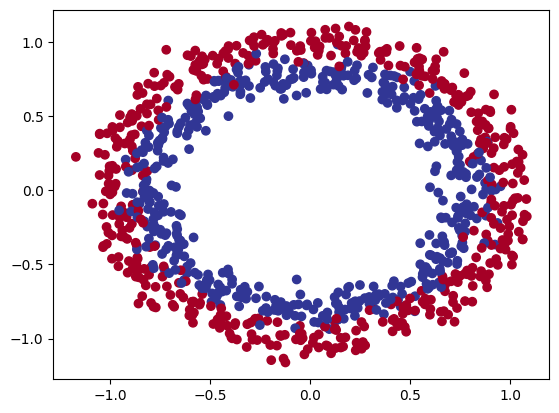

In [5]:
plt.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

# turn dataset into Tensors

In [7]:
torch.__version__

'2.4.0+cpu'

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7302,  0.2619],
         [-0.7119,  0.1841],
         [-0.8443,  0.2706],
         [-0.4645,  0.6516],
         [ 0.4490, -0.8931]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# define the classification model from nn.Module

In [13]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
    def forward(self,X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

In [14]:
model3 = CircleModelV3().to(device)

In [15]:
def relu(x):
	return max(0.0, x)

In [16]:
x = [-1,-2,-3,3,4,5]
list(map(relu,x))

[0.0, 0.0, 0.0, 3, 4, 5]

In [17]:
model3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [18]:
model3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.2033,  0.0105],
                      [ 0.2149, -0.5640],
                      [ 0.7017,  0.4569],
                      [-0.3125,  0.4410],
                      [-0.5763, -0.5558],
                      [-0.4511, -0.6015],
                      [ 0.5421, -0.3160],
                      [-0.0354,  0.4192],
                      [-0.5488, -0.3112],
                      [-0.0399,  0.4019]])),
             ('layer_1.bias',
              tensor([-0.2184, -0.4148,  0.5890,  0.3410, -0.3286, -0.0352, -0.3834,  0.0609,
                      -0.5590, -0.0029])),
             ('layer_2.weight',
              tensor([[ 0.2445, -0.1138, -0.0986,  0.2654,  0.2149, -0.3149, -0.0551,  0.1703,
                       -0.2799,  0.1855],
                      [-0.3006,  0.2165,  0.1722, -0.1296,  0.1857,  0.1633, -0.0079,  0.0260,
                        0.2167, -0.1825],
                      [ 0.1210,  0.0294,  0.1716, -0.1958, -0.1468,  0.0

In [19]:
loss_fn = nn.BCEWithLogitsLoss() # expects logits as the input instead of y_pred if the loss func is BCELoss it would expect pred probs
optimizer = torch.optim.SGD(params=model3.parameters(),lr=0.15)

In [20]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct*100.0/len(y_pred)
    return acc

In [21]:
with torch.inference_mode():
    y_logits = model3(X_test).to(device)[:5]
    y_pred_probs = torch.sigmoid(y_logits).squeeze()
    torch.round(y_pred_probs)

In [22]:
epochs = 1000

In [23]:
torch.manual_seed(42)
for epoch in range(epochs):
    model3.train()
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # calculate acc/ loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    #optimizer
    optimizer.zero_grad()
    # loss_backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #testing
    model3.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate test loss /acc
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss {loss:.5f} acc {acc:.2f} test loss {test_loss:.5f} test acc {test_acc:.2f}")
        

Epoch 0 loss 0.69294 acc 50.86 test loss 0.69739 test acc 48.00
Epoch 10 loss 0.69031 acc 50.86 test loss 0.69362 test acc 48.00
Epoch 20 loss 0.68910 acc 58.14 test loss 0.69189 test acc 53.67
Epoch 30 loss 0.68837 acc 59.86 test loss 0.69092 test acc 57.00
Epoch 40 loss 0.68773 acc 61.29 test loss 0.69025 test acc 60.67
Epoch 50 loss 0.68712 acc 62.43 test loss 0.68970 test acc 61.33
Epoch 60 loss 0.68650 acc 63.86 test loss 0.68920 test acc 65.33
Epoch 70 loss 0.68586 acc 63.86 test loss 0.68871 test acc 64.00
Epoch 80 loss 0.68520 acc 63.86 test loss 0.68820 test acc 63.67
Epoch 90 loss 0.68450 acc 64.57 test loss 0.68767 test acc 64.00
Epoch 100 loss 0.68377 acc 64.14 test loss 0.68713 test acc 62.33
Epoch 110 loss 0.68301 acc 64.43 test loss 0.68656 test acc 62.00
Epoch 120 loss 0.68220 acc 64.71 test loss 0.68596 test acc 62.33
Epoch 130 loss 0.68134 acc 64.43 test loss 0.68532 test acc 62.67
Epoch 140 loss 0.68040 acc 64.86 test loss 0.68463 test acc 62.00
Epoch 150 loss 0.6793

# visualize the predictions 

In [24]:
import requests
from pathlib import Path

In [25]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping the download")
else:
    print("downloading the helper_functions.py ...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping the download


In [26]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [27]:
# import numpy as np
# def plot_decision_boundary(model, X, y):
#     x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#     y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
#     cmap = plt.cm.Spectral

#     X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
#     y_logits = model_circle_v1(X_test).squeeze()
#     y_pred = torch.round(torch.sigmoid(y_logits)).detach().numpy()
#     # _, y_pred = y_pred.max(dim=1)
#     y_pred = y_pred.reshape(xx.shape)
#     plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

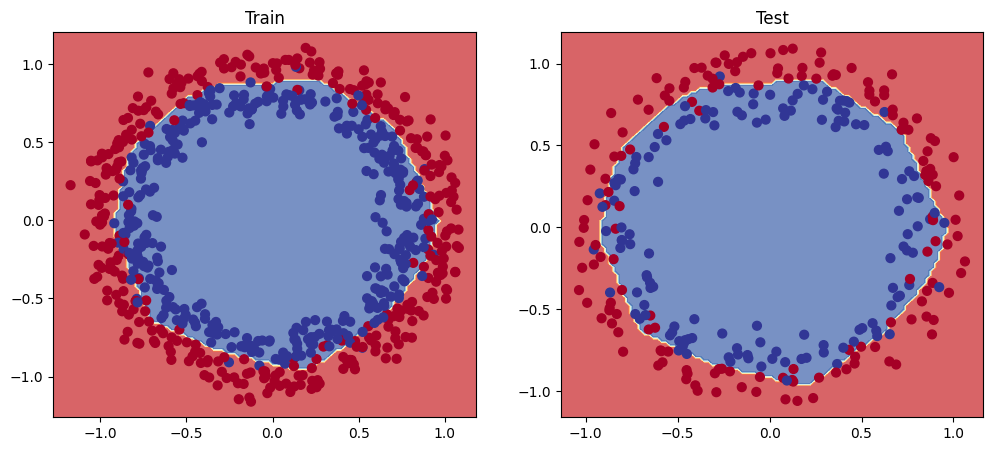

In [28]:
# Visualize the decision boundary
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model3, X=X_test, y=y_test)

In [29]:
model3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.9522,  0.2342],
                      [ 0.7661, -2.0342],
                      [ 0.3205,  0.1140],
                      [-0.7251,  1.8248],
                      [-1.4985, -0.6198],
                      [-0.7792, -1.1814],
                      [ 2.2650, -0.0905],
                      [ 0.5781,  1.1007],
                      [-1.3248, -0.0686],
                      [ 0.5529,  1.2504]])),
             ('layer_1.bias',
              tensor([-0.5018, -0.7585,  0.9792, -0.5541, -0.2486, -0.2733, -0.5253, -0.0606,
                      -0.4071, -0.2635])),
             ('layer_2.weight',
              tensor([[ 0.2979, -0.1138, -0.0780,  0.3770,  0.2664, -0.2929, -0.0506,  0.2315,
                       -0.2414,  0.2533],
                      [-0.3015,  0.1332,  0.0961, -0.1330,  0.0959,  0.0377, -0.0191,  0.0248,
                        0.2004, -0.1832],
                      [-0.0492, -0.2731,  0.3970, -0.4866, -0.3213, -0.0